# Model Comparison: when do differences matter?

We'll pick up from where we left off on Monday.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn import datasets
from sklearn import cluster
from sklearn import svm
from sklearn import tree
# import the whole model selection module
from sklearn import model_selection
sns.set_theme(palette='colorblind')

````{margin}
```{admonition} Further Reading

If you struggled to understand this code excerpt to fill in the comments, some generic strategies to understand code may help, beyond applying what we have covered in class.

[The Programmer's brain](https://www.manning.com/books/the-programmers-brain)
is an overview of how brains work, as applied to programming, written for working
developers. This means that it assumes you know most CS concepts and at least two programming languages. If you don't there may be some parts that do not make sense to you, but the general ideas should still make sense.
The author is a professor who researchers how people learn
programming and how to effectively teach it.


This book is available for free online, including an audio version of the first chapter.

**I strongly recommend this if you have trouble remembering things**
```
````

In [2]:
# load data, 20% test
iris_X, iris_y = datasets.load_iris(return_X_y=True)
iris_X_train, iris_X_test, iris_y_train, iris_y_test = model_selection.train_test_split(
  iris_X,iris_y, test_size =.2)


# setup DT & params
dt = tree.DecisionTreeClassifier()

params_dt = {'criterion':['gini','entropy'],
       'max_depth':[2,3,4,5,6],
    'min_samples_leaf':list(range(2,20,2))}

dt_opt = model_selection.GridSearchCV(dt,params_dt)


# optmize DT
dt_opt.fit(iris_X_train,iris_y_train)

# store DT results in dataframe
dt_df = pd.DataFrame(dt_opt.cv_results_)


# setup svm and params
svm_clf = svm.SVC()
param_grid = {'kernel':['linear','rbf'], 'C':[.5, .75,1,2,5,7, 10]}
svm_opt = model_selection.GridSearchCV(svm_clf,param_grid)

# optmize and save svm results
svm_opt.fit(iris_X_train,iris_y_train)
sv_df = pd.DataFrame(svm_opt.cv_results_)

```{important}

This is extra detail we did not do in class for time reasons
```
We can  use EDA to understand how the score varied across all of the parameter settings we tried.

In [3]:
sv_df['mean_test_score'].describe()

count    14.000000
mean      0.978571
std       0.012957
min       0.950000
25%       0.975000
50%       0.983333
75%       0.983333
max       1.000000
Name: mean_test_score, dtype: float64

In [4]:
dt_df['mean_test_score'].describe()

count    90.000000
mean      0.928333
std       0.007474
min       0.925000
25%       0.925000
50%       0.925000
75%       0.925000
max       0.950000
Name: mean_test_score, dtype: float64

From this we see that in both cases the standard deviation (std) is really
low. This tells us that the parameter changes didn't impact the performance
much.  Combined with the overall high accuracy this tells us that the data
is probably really easy to classify.  If the performance had been uniformly
bad, it might have instead told us that we did not try a wide enough range
of parameters.

To confirm how many parameter settings we have used we can check a couple different ways. First, above in the count of the describe.

We can also calculate directly from the parameter grids before we even do the fit.

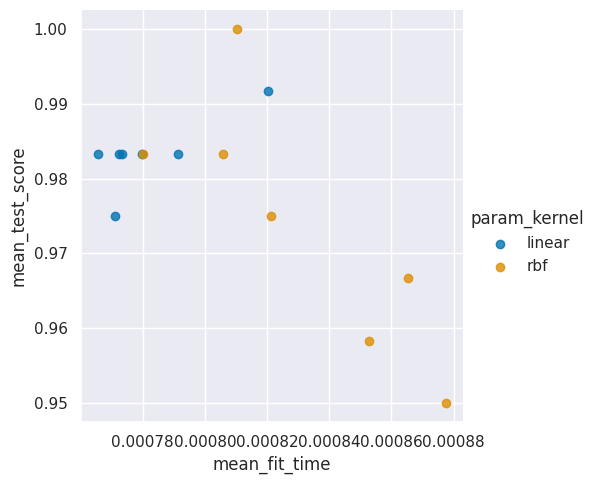

In [5]:
description_vars = ['param_C', 'param_kernel', 'params',]
vars_to_plot = ['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time']
svm_time = sv_df.melt(id_vars= description_vars,
           value_vars=vars_to_plot)
sns.lmplot(data=sv_df, x='mean_fit_time',y='mean_test_score',
     hue='param_kernel',fit_reg=False)

In [6]:
len(iris_X_train)/5

24.0

In [7]:
23/24

0.9583333333333334

In [8]:
svm_opt.predict_proba

AttributeError: predict_proba is not available when  probability=False

## When do differences matter?

We can check calculate a confidence interval to determine more precisely when the performance of two models is meaningfully different.  


This function calculates the 95% confidence interval.  The range within which we are 95% confident the quantity we have estimated is truly within in.  When we have more samples in the test set used to calculate the score, we are more confident in the estimate, so the interval is narrower.

In [9]:
def classification_confint(acc, n):
    '''
    Compute the 95% confidence interval for a classification problem.
    acc -- classification accuracy
    n -- number of observations used to compute the accuracy
    Returns a tuple (lb,ub)
    '''
    interval = 1.96*np.sqrt(acc*(1-acc)/n)
    lb = max(0, acc - interval)
    ub = min(1.0, acc + interval)
    return (lb,ub)

We can calculate the number of observations used to compute the accuracy using the size of the training data and the fact that we set it to 10-fold cross validation. That means that 10% (100/10) of the data was used for each fold and each validation set.

In [10]:
type(dt_opt)

sklearn.model_selection._search.GridSearchCV

In [11]:
dt_opt.best_score_, svm_opt.best_score_

(0.95, 1.0)

In [12]:
classification_confint(dt_opt.best_score_, len(iris_X_train))

(0.9110047011380431, 0.9889952988619568)

We can see how more samples narrows the range.

In [13]:
classification_confint(dt_opt.best_score_, len(iris_X_train)*10)

(0.9376686037557244, 0.9623313962442755)

We would say that two model sare different if their intervals do not overlap.

## Questions after class?

### What is the data type of the dt_opt and svm_opt variables? In Python it says sklearn.model_selection._search.GridSearchCV for them, but what about in plain human language? It is a model or a group of models?

This is an object of a sort of complex type, a Grid search object is really the only name for the whole thing, but it is easier to understand part by part.  

It has some attributes that are metrics and one attribute that is the a model.

In [14]:
svm_opt.best_estimator_.score(iris_X_test,iris_y_test)

0.9666666666666667

In [15]:
dt_opt.best_estimator_.score(iris_X_test,iris_y_test)

0.9333333333333333